# Support Vector Machines

Typically used for **classification**, **regression**, and **outlier detection**.

SVMs are:
- Strong in high dimensional spaces.
- Robust models where there are more features than samples.
- The decision function is built partly by training points, these are known as **support vectors**, making it memory efficient.
- With the use of **kernel functions**, the model can stay versatile. Custom kernels can be applied.

However, some disadvantages:
- If the number of features is **much greater** than the number of samples, the correct Kernel function and regularization parameter is crucial to avoid over-fitting.
- The model itself does not directly provide probability estimates, but are rather calculated using an expensive five-fold cross validation.

In [14]:
import pandas as pd

In [15]:
water_quality = pd.read_csv('../Class_Data/water quality.csv')

In [16]:
water_quality.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,0.00,9.80,0.90,2.08,0.040,5.92,0.57,0.03,0.95,0.33,...,0.072,3.55,2.08,0.002,27.82,4.53,0.02,0.11,0.02,No
1,0.05,18.85,0.04,0.73,0.040,0.06,0.00,0.08,0.13,0.00,...,0.132,9.40,0.40,0.006,0.21,4.66,0.00,0.02,0.06,No
2,4.49,3.08,0.01,3.28,0.002,7.43,0.29,1.67,0.47,0.54,...,0.141,4.94,1.64,0.006,45.28,0.80,0.04,0.40,0.03,Yes
3,3.61,21.65,0.24,1.32,0.050,4.80,0.08,1.65,0.03,0.17,...,0.067,6.07,1.69,0.001,24.15,2.73,0.03,0.19,0.00,No
4,0.01,16.13,0.05,0.57,0.070,0.09,0.07,1.14,1.14,0.00,...,0.045,9.14,0.87,0.010,0.14,2.30,0.02,0.05,0.04,Yes


In [17]:
X = water_quality.drop('is_safe', axis=1)
y = water_quality['is_safe'].map({'Yes': 1, 'No': 0})

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_classifier', SVC())
])

# Use rbf and scale gamma by default
clf = GridSearchCV(
    estimator=pipe,
    param_grid={
        'svm_classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        'svm_classifier__class_weight': ['balanced', 
            {0: 2, 1: 1},
            {0: 5, 1: 1},
            {0: 10, 1: 1},
            {0: 20, 1: 1}
        ]
    },
    cv=5,
    scoring='precision',
    n_jobs=-1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [19]:
print("Best Validation Score:", clf.best_score_)
clf.best_params_

Best Validation Score: 1.0


{'svm_classifier__C': 0.1, 'svm_classifier__class_weight': {0: 5, 1: 1}}

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.6649874055415617
Precision: 1.0
Recall: 0.07317073170731707


<Figure size 500x500 with 0 Axes>

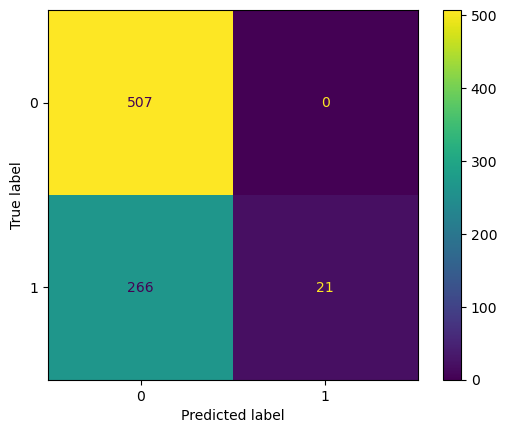

In [28]:
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    PrecisionRecallDisplay, 
    RocCurveDisplay
)

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_test,
        y_pred
    ),
    display_labels=clf.classes_
)
disp.plot()


<Figure size 500x500 with 0 Axes>

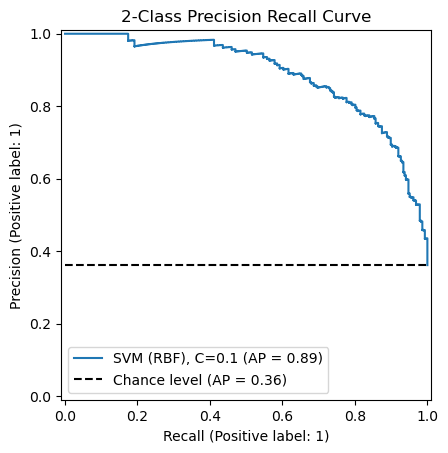

In [37]:
plt.figure(figsize=(5, 5))
disp = PrecisionRecallDisplay.from_estimator(
    X=X_test,
    y=y_test,
    estimator=clf,
    name=f'SVM (RBF), C={clf.best_params_['svm_classifier__C']}',
    plot_chance_level=True,
    despine=False
)
_ = disp.ax_.set_title('2-Class Precision Recall Curve')

<Figure size 500x500 with 0 Axes>

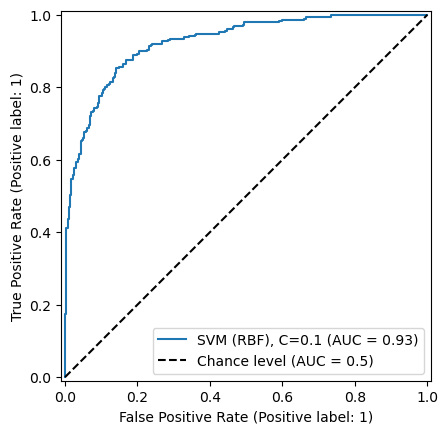

In [38]:
plt.figure(figsize=(5, 5))
RocCurveDisplay.from_estimator(
    estimator=clf,
    X=X_test,
    y=y_test,
    name=f'SVM (RBF), C={clf.best_params_['svm_classifier__C']}',
    plot_chance_level=True,
    despine=False
)

## Regression

In [45]:
mall_customers = pd.read_csv('../Class_Data/mall customers.csv')

In [47]:
mall_customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV

preprocessor = ColumnTransformer([
    ('binarizer', OneHotEncoder(drop='if_binary'), ['Gender']),
    ('normalizer', StandardScaler(), ['Age', 'Annual Income (k$)'])
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('SVM_regressor', SVR())
])

X = mall_customers.drop(['CustomerID', 'Spending Score (1-100)'], axis=1)
y = mall_customers['Spending Score (1-100)']

# Use rbf and scale gamma by default
clf = GridSearchCV(
    estimator=pipe,
    param_grid={
        'SVM_regressor__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [64]:
clf.best_score_

np.float64(-24.672717303128046)

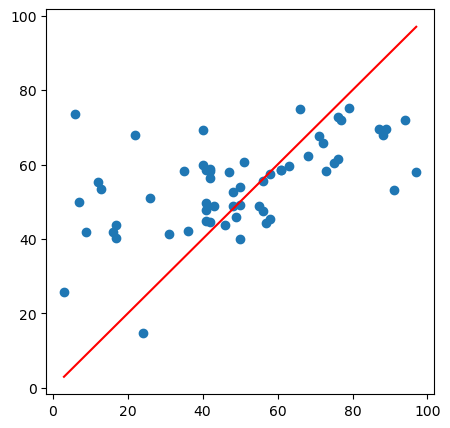

R^2:  0.24375473866856323


In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Build a scatterplot
plt.figure(figsize= (5, 5))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
plt.show()

print("R^2: ", r2_score(y_test, y_pred))

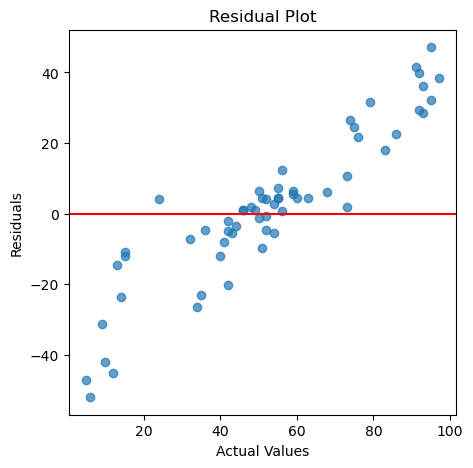

In [58]:
residuals = y_test - y_pred

plt.figure(figsize=(5, 5))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='r')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

While the model posed a very strong classifier, there appears to be other factors at play when regression is attempted to be used. The residual plot shows a linear relationship, which implies that the relationship is not linear and dimensionality reduction is required to improve this model.